In [9]:
import os
import sys
import rand_compare
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftshift, ifft2

In [2]:
class HMEq_data:
    head = ("head", "<i")
    tail = ("tail", "<i")

    def __init__(self, nx=512, ny=512, lx=300, ly=300) -> None:
        pass
        self.nx, self.ny = nx, ny
        self.nkx, self.nky = (nx-2)//3, (ny-2)//3
        self.lx, self.ly = lx, ly
        self.dx, self.dy = lx/nx, ly/ny
        self.xx = np.linspace(0, lx, nx)
        self.yy = np.linspace(0, ly, ny)
        self.XX, self.YY = np.meshgrid(self.xx, self.yy)
        self.dt_pk = np.dtype(
            [self.head, ("pk", "{0}<c16".format((2*self.nkx+1)*(self.nky+1))), self.tail])
        self.dt_time = np.dtype([self.head, ("time", "<d"), self.tail])
        self.pk_size = self.dt_pk.itemsize
        self.time_size = self.dt_time.itemsize

    def __del__(self):
        pass

    def datafile_phi(self, ifrun, t_spc=100, data_dir='./'):
        ph_data = np.empty((0, (self.nx)*(self.ny)), dtype=float)
        iter_global = 0
        for ifile in np.arange(1, ifrun):
            fd_pk = open(data_dir+"data/pk_{0:03}.bin".format(ifile), "rb")
            fd_time = open(data_dir+"data/time_{0:03}.bin".format(ifile), "rb")
            chunk_time = np.fromfile(fd_time, dtype=self.dt_time, count=10000)
            for iter in range(chunk_time.size):
                iter_global += 1
                if(iter_global % t_spc == 0):
                    fd_pk.seek(iter*self.pk_size)
                    chunk_pk = np.fromfile(fd_pk, dtype=self.dt_pk, count=1)
                    pk_tmp = chunk_pk[0]["pk"].reshape(
                        (2*self.nkx+1, self.nky+1), order="F")
                    ph_tmp = self._fft_backward(pk_tmp).flatten()
                    ph_data = np.append(ph_data, np.array([ph_tmp]), axis=0)
        return ph_data

    def _fft_backward(self, pk):
        pk_lx = 2*self.nkx+1
        pk_ly = self.nky+1

        pk_full = np.zeros((pk_lx, pk_ly+self.nky), dtype='c16')
        ph = np.zeros((self.nx, self.ny), dtype='c16')

        # in HMEq_FFTW, normalization coeff is applied at forward transformation
        # (caution!! ↑that treatment is different from ordinal FFT procedure!!# )
        # realistic condition enforcing pattern
        coeff_norm = self.nx*self.ny

        for i in range(pk_lx):
            for j in range(pk_ly):
                pk_full[i, j+self.nky] = coeff_norm*pk[i, j]
        for i in range(pk_lx):
            for j in range(1, self.nky+1):
                ikx = i-self.nkx
                iky = j
                pk_full[i, j] = coeff_norm * \
                    pk[self.nkx-ikx, self.nky-iky].conjugate()

        # copy from pk_full to ph
        for i in range(pk_lx):
            for j in range(pk_ly+self.nky):
                ist = self.nx//2-self.nkx
                jst = self.ny//2-self.nky
                ph[i+ist, j+jst] = pk_full[i, j]
        phr = fftshift(ph)
        return np.real(ifft2(phr))

In [3]:
def gen_rand(seed=0):
    np.random.seed(seed)
    phi_rand = np.random.rand(nx, ny)
    return phi_rand


def sampling_down(phi, ndx=128, ndy=128):
    nx = phi.shape[0]
    ny = phi.shape[1]
    xstep = nx//ndx
    ystep = ny//ndy
    phi_down = phi[::xtep, ::ystep]
    return phi_down

In [4]:
ph_fd = HMEq_data()

In [14]:
ph = ph_fd.datafile_phi(5, data_dir='./diff-2force1/res512/psi10/')

In [24]:
# set physical parameters
nx,ny = ph_fd.nx,ph_fd.ny
lx,ly = ph_fd.lx,ph_fd.ly
xx,yy=np.linspace(0,lx,nx), np.linspace(0,ly,ny)
XX,YY = np.meshgrid(xx,yy)


Text(0.5, 0.98, '2D Turbulence Structure')

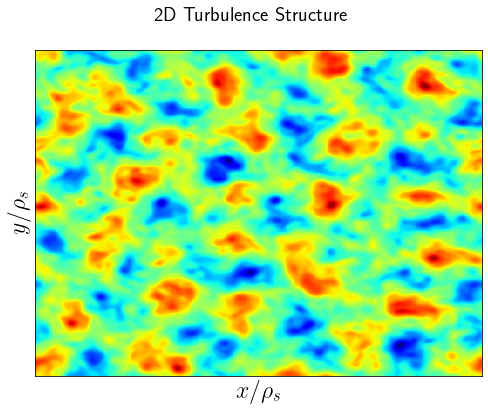

In [25]:
from matplotlib import rc
rc('text', usetex=True)

ph_tmp = ph[64].reshape((ph_fd.nx,ph_fd.ny))
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\displaystyle x/\rho_s$',size=24)
ax.set_ylabel(r'$\displaystyle y/\rho_s$',size=24)
ax.pcolormesh(XX,YY,ph_tmp, shading='auto',cmap='jet')
# skip ticks
ax.set_xticks([])
ax.set_yticks([])
# Description of the figure.
fig.suptitle('2D Turbulence Structure',size=20)